# II - Accessing Astronomical Data From Python

Before doing to data analysis, we need to find, load and pre-process data!

## 1.- Astronomical Data from WebPages

Function to retrieve the tarball and the fits file.

In [1]:
import os
import urllib.request
import tarfile
import sys

global DOWNLOADS_DIR 
DOWNLOADS_DIR= '.'

def download_and_extract(url):
    # Obtain the filename
    name = url.rsplit('/', 1)[-1]
    filename = os.path.join(DOWNLOADS_DIR, name)
    # Download the file if not found
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url, filename)
    # Decompress (if needed) and copy the selected file to the DOWNLOADS_DIR
    sdir=filename.rsplit('ReferenceImages',1)[0]+"ReferenceImages"
    if not os.path.isdir(sdir):
        tar = tarfile.open(filename)
        tar.extractall(path=DOWNLOADS_DIR)
        tar.close()

In [2]:
# Data from ALMA science verification 
twhydra_url = 'https://almascience.nrao.edu/almadata/sciver/TWHya/TWHYA_BAND7_ReferenceImages.tgz'
download_and_extract(twhydra_url)

!ls TWHYA_BAND7_ReferenceImages

TWHydra_CO3_2line.image.fits
TWHydra_CO3_2line.image.mom0.fits
TWHydra_CO3_2line.image.mom.weighted_coord.fits
TWHydra_CO3_2line.image.mom.weighted_dispersion_coord.fits
TWHydra_contall_apcal.image.fits
TWHydra_HCOplusline.image.fits
TWHydra_HCOplusline.image.mom0.fits
TWHydra_HCOplusline.image.mom.weighted_coord.fits
TWHydra_HCOplusline.image.mom.weighted_dispersion_coord.fits


## 2.- Loading and a Quick Look at the Data

In [3]:
from astropy.io import fits
import logging
import warnings
warnings.filterwarnings('ignore')

# Load File
hdulist = fits.open("TWHYA_BAND7_ReferenceImages/TWHydra_CO3_2line.image.mom0.fits")
twhydra = hdulist[0]

### Show the header

In [4]:
twhydra.header

SIMPLE  =                    T /Standard FITS                                   
BITPIX  =                  -32 /Floating point (32 bit)                         
NAXIS   =                    4                                                  
NAXIS1  =                  100                                                  
NAXIS2  =                  100                                                  
NAXIS3  =                    1                                                  
NAXIS4  =                    1                                                  
BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 
BZERO   =   0.000000000000E+00                                                  
BMAJ    =   4.668472210566E-04                                                  
BMIN    =   4.255372948117E-04                                                  
BPA     =   2.230152130127E+01                                                  
BTYPE   = 'Intensity'       

### Quick Look
We can use matplotlib

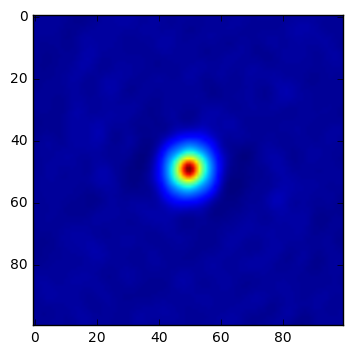

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(twhydra.data.sum(axis=(0,1)))

INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -9.227e-01 [aplpy.core]
INFO: Auto-setting vmax to  7.636e+00 [aplpy.core]


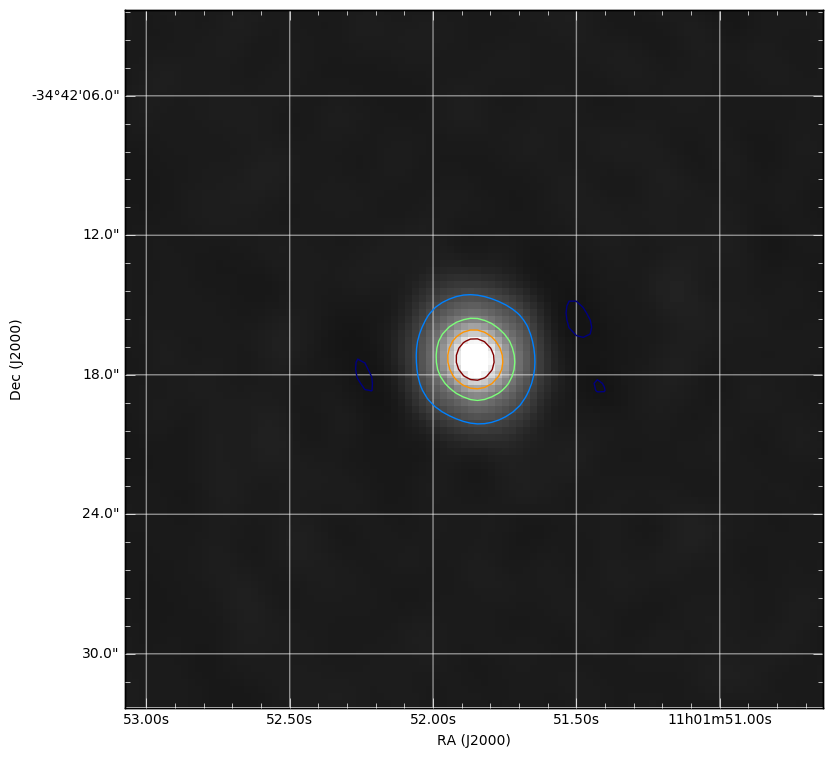

In [6]:
import aplpy 
fig = aplpy.FITSFigure(twhydra)
fig.show_grayscale()
fig.show_grid()
fig.show_contour()

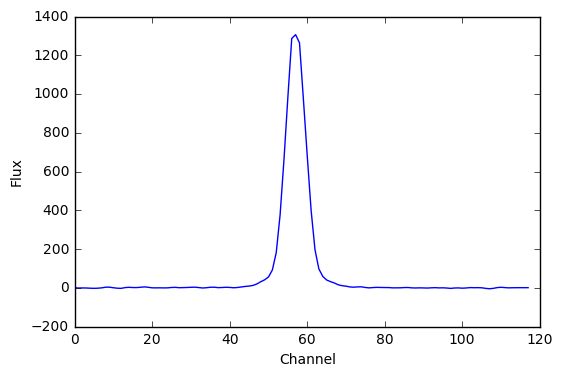

In [7]:
#Load Data Cube
hdulist = fits.open("TWHYA_BAND7_ReferenceImages/TWHydra_CO3_2line.image.fits")
twhydra_cube = hdulist[0]

def show_spectra(cube):
    spec = cube.sum(axis=(0,2,3))
    plt.plot(spec)
    plt.ylabel('Flux')
    plt.xlabel('Channel')

show_spectra(twhydra_cube.data)
plt.show()

## Interactivity

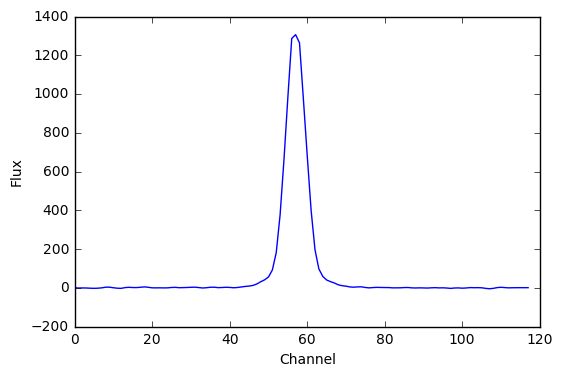

In [8]:
from ipywidgets import interact

def interactive_denoising(threshold=0.0):
    cube=twhydra_cube.data.copy()
    cube[cube<threshold] = 0
    show_spectra(cube)
    plt.show()

mmax = twhydra_cube.data.max()
mmin = twhydra_cube.data.min()
print(mmax,mmin)
res=interact(interactive_denoising,threshold=(mmin,mmax))

In [9]:
limits = res.widget.kwargs
limits

{'threshold': 0.0}

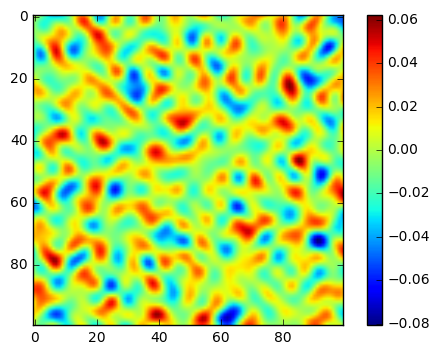

In [13]:
cube=twhydra_cube.data[0]
def explore_channels(chan=0):
    plt.imshow(cube[chan])
    plt.colorbar()
    plt.show()

interact(explore_channels,chan=(0,cube.shape[0]-1))

## 3 Catalog Access

In [15]:
from astroquery.skyview import SkyView
SkyView.list_surveys()

{'All:GOODS/HDF/CDF': ['GOODS: Chandra ACIS HB',
                       'GOODS: Chandra ACIS FB',
                       'GOODS: Chandra ACIS SB',
                       'GOODS: VLT VIMOS U',
                       'GOODS: VLT VIMOS R',
                       'GOODS: HST ACS B',
                       'GOODS: HST ACS V',
                       'GOODS: HST ACS I',
                       'GOODS: HST ACS Z',
                       'Hawaii HDF U',
                       'Hawaii HDF B',
                       'Hawaii HDF V0201',
                       'Hawaii HDF V0401',
                       'Hawaii HDF R',
                       'Hawaii HDF I',
                       'Hawaii HDF z',
                       'Hawaii HDF HK',
                       'GOODS: HST NICMOS',
                       'GOODS: VLT ISAAC J',
                       'GOODS: VLT ISAAC H',
                       'GOODS: VLT ISAAC Ks',
                       'HUDF: VLT ISAAC Ks',
                       'GOODS: Spitzer IRAC 3

In [16]:
res=SkyView.get_image_list(position='Galactic Center',survey=['DSS'])
res

['http://skyview.gsfc.nasa.gov/tempspace/fits/skv8295383459493.fits']

INFO: Auto-setting vmin to  5.602e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.064e+04 [aplpy.core]


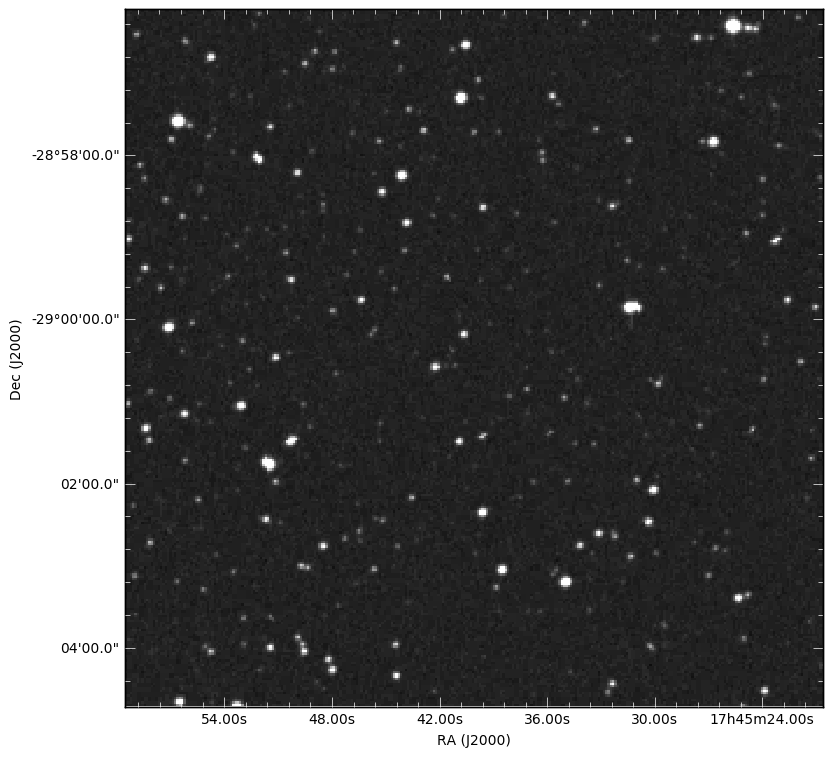

In [17]:
urllib.request.urlretrieve(res[0],'opt.fits')
hdulist = fits.open("opt.fits")
opt = hdulist[0] 
fig = aplpy.FITSFigure(opt)
fig.show_grayscale()

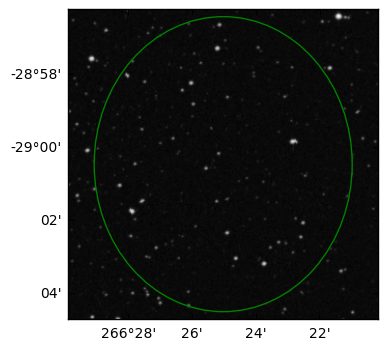

In [20]:

from astropy.wcs import WCS
from matplotlib.patches import Circle
ra=opt.header['CRVAL1']
dec=opt.header['CRVAL2']
mywcs=WCS(opt.header)
max_radius=0.09

def select_radius(radius=max_radius):
    ax=plt.subplot(111,projection=mywcs)
    ax.imshow(opt.data,cmap="gray",origin='lower')
    cc=Circle((ra,dec),radius=radius,edgecolor="green",facecolor="none",transform=ax.get_transform('fk5'))
    ax.add_patch(cc)
    
mycirc=interact(select_radius,radius=(0.0,max_radius,max_radius/1000))

In [21]:
limits = mycirc.widget.kwargs
rad    = limits['radius']
print(ra,dec)
rad

266.417 -29.0078


0.06741

In [22]:
from astroquery.vizier import Vizier
catalog_list = Vizier.find_catalogs(keywords=['GAIA'])
for key,item in catalog_list.items():
    print(key+" : "+item.description)

J/A+A/406/995 : 8500-8750{AA} high resolution spectroscopy. IV. (Marrese+, 2003)
J/MNRAS/426/1767 : Gaia spectrophotometric standard stars I. (Pancino+, 2012)
J/A+A/573/A115 : Radial velocities in seven globular clusters (Lardo+, 2015)
J/ApJ/811/85 : RVs & V-band LCs of probable members of Cyg OB2 (Kiminki+, 2015)
J/A+A/592/A70 : Gaia FGK stars: low-metallicities candidates (Hawkins+, 2016)
J/A+A/591/A37 : Gaia-ESO Survey. Parameters for cluster members (Jacobson+, 2016)
J/A+A/406/751 : Close encounters of asteroids 2003-2020 (Fienga+, 2003)
J/A+A/591/A74 : Nebular emission lines towards NGC3372 center (Damiani+, 2016)
J/AJ/140/1758 : Spectral atlas of peculiar stars (Tomasella+, 2010)
J/A+A/574/L7 : Gaia-ESO Survey: Li-rich stars in NGC2547 (Sacco+, 2015)
J/A+A/538/A38 : Synthetic galaxy spectra (Karampelas+, 2012)
J/A+A/575/A4 : Activity and accretion in {gamma} Vel and Cha I (Frasca+, 2015)
J/A+A/597/A10 : SEP stars radial velocities (Fremat+, 2017)
J/A+A/546/A61 : Radial velocities

In [24]:
from astropy.coordinates import SkyCoord
import astropy.units as u

c = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
res=Vizier.query_region(c, radius=rad*u.deg, catalog='I/337')

In [25]:
restab=res[0]
restab

_RAJ2000,_DEJ2000,_r,RA_ICRS,e_RA_ICRS,DE_ICRS,e_DE_ICRS,SolID,Source,RandomI,Epoch,Plx,e_Plx,pmRA,e_pmRA,pmDE,e_pmDE,RADEcor,RAPlxcor,RApmRAcor,RApmDEcor,DEPlxcor,DEpmRAcor,DEpmDEcor,PlxpmRAcor,PlxpmDEcor,pmRApmDEcor,NAL,NAC,NgAL,NgAC,NbAL,NbAC,DQ,epsi,sepsi,APF,ARF,WAL,WAC,Apr,MatchObs,Dup,sK1,sK2,sK3,sK4,mK1,mK2,mK3,mK4,o__Gmag_,__FG_,e__FG_,__Gmag_,Var,GLON,GLAT,ELON,ELAT
deg,deg,deg,deg,mas,deg,mas,,,,yr,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,,mas,,,,1 / mas2,1 / mas2,,,,,,,,deg,deg,deg,deg,,e-/s,e-/s,mag,,deg,deg,deg,deg
float64,float64,float64,float64,float32,float64,float32,int64,int64,int64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,float64,float32,float32,uint8,float32,float64,float32,uint8,int16,uint8,float32,float32,float32,float32,float64,float64,float64,float64,int16,float32,float32,float32,bytes13,float64,float64,float64,float64
266.4061011,-29.0708877,0.063810,266.4061011390,2.133,-29.0708877388,1.849,1635378410781933568,4057468283280793088,483323862,2015.0,--,--,--,--,--,--,0.849,--,--,--,--,--,--,--,--,--,53,0,53,0,0,0,0.00,0.00,0,0,1.00,0.096,--,2,8,0,0.398,0.417,0.535,0.943,-87.75912500,-34.69429800,-29.93820200,-43.76815000,53,229.4,3.011,19.623,NOT_AVAILABLE,359.8855203337,-0.0710151469,266.8439014021,-5.6709718439
266.4074682,-29.0700875,0.062849,266.4074681620,2.116,-29.0700874536,1.796,1635378410781933568,4057468287570055424,1124448172,2015.0,--,--,--,--,--,--,0.979,--,--,--,--,--,--,--,--,--,60,0,59,0,1,0,0.00,1.01,2.7,0,4.03,0.317,--,2,7,0,0.264,0.732,0.338,0.960,-70.07652000,-39.95046000,-33.17992800,-42.79451400,59,824.5,3.696,18.234,NOT_AVAILABLE,359.8868259298,-0.0716180119,266.8450815624,-5.6701418775
266.3981105,-29.0722070,0.066498,266.3981105188,8.220,-29.0722070390,7.320,1635378410781933568,4057468351995073024,222577732,2015.0,--,--,--,--,--,--,0.998,--,--,--,--,--,--,--,--,--,50,0,50,0,0,0,0.00,1.11,1.4,0,1.54,0.200,--,2,6,0,0.279,0.995,0.271,0.980,-39.48425700,-41.53788000,-39.47412000,-41.56096000,50,516.1,2.573,18.743,NOT_AVAILABLE,359.8807553104,-0.0657416139,266.8369185985,-5.6724659185
266.4035159,-29.0714492,0.064738,266.4035158798,1.875,-29.0714491774,1.606,1635378410781933568,4057468351995074048,351088199,2015.0,--,--,--,--,--,--,0.979,--,--,--,--,--,--,--,--,--,61,0,61,0,0,0,0.00,1.07,3.7,0,1.44,0.375,--,2,7,0,0.285,0.741,0.356,0.961,-67.15420500,-40.11751000,-34.10610200,-42.82615000,60,1064,3.554,17.957,NOT_AVAILABLE,359.8838638248,-0.0693790516,266.8416455832,-5.6715897440
266.3948312,-29.0719264,0.066999,266.3948312213,0.494,-29.0719264212,0.437,1635378410781933568,4057468351995074176,352190964,2015.0,--,--,--,--,--,--,0.915,--,--,--,--,--,--,--,--,--,69,0,68,0,1,0,0.00,0.60,5.1,0,1.35,1.313,--,2,8,0,0.302,0.540,0.400,0.955,-90.10152400,-38.03735000,-29.80552100,-43.58221400,68,3082,5.138,16.803,NOT_AVAILABLE,359.8795013022,-0.0631491346,266.8340321830,-5.6722573981
266.3996538,-29.0706143,0.064626,266.3996538304,7.432,-29.0706142791,6.703,1635378410781933568,4057468351995075328,262627831,2015.0,--,--,--,--,--,--,0.999,--,--,--,--,--,--,--,--,--,52,0,51,0,1,0,0.00,1.07,5.7,0,1.48,0.450,--,2,7,0,0.293,0.995,0.285,0.981,-40.32936000,-41.74601400,-40.33879000,-41.76854000,51,1520,4.266,17.570,NOT_AVAILABLE,359.8828176149,-0.0660629536,266.8382334978,-5.6708397943
266.3982138,-29.0678537,0.062266,266.3982137768,2.351,-29.0678536726,2.009,1635378410781933568,4057468351995079424,801130207,2015.0,--,--,--,--,--,--,0.977,--,--,--,--,--,--,--,--,--,61,0,60,0,1,0,0.00,1.22,2.4,0,1.50,0.230,--,2,7,0,0.275,0.736,0.347,0.961,-68.59554000,-40.05869000,-33.70810700,-42.82739300,60,668.5,5.412,18.462,NOT_AVAILABLE,359.8845179782,-0.0635502005,266.8368994041,-5.6681116586
266.3940740,-29.0665133,0.062048,266.3940739505,1.726,-29.0665133383,1.466,1635378410781933568,4057468351995081344,945178707,2015.0,--,--,--,--,--,--,0.977,--,--,--,--,--,--,--,

INFO: Auto-setting vmin to  5.602e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.064e+04 [aplpy.core]


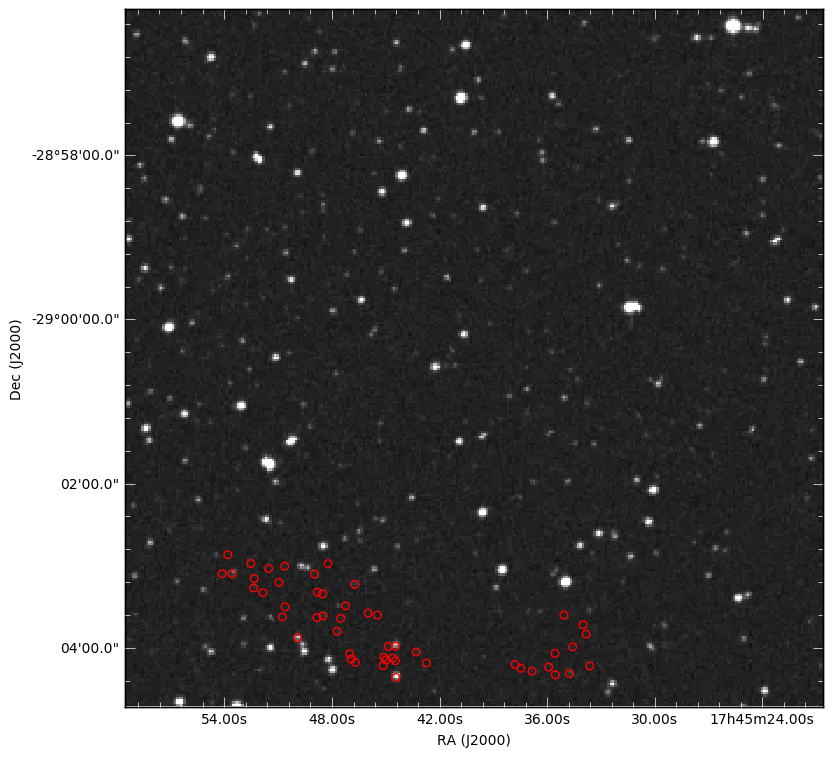

In [26]:
fig = aplpy.FITSFigure(opt)
fig.show_grayscale()
#fig.show_markers(restab['ra'],restab['dec'])
fig.show_markers(restab['RA_ICRS'],restab['DE_ICRS'])

### With ALMA

In [27]:
res=SkyView.get_image_list(position='Galactic Center',survey=['NVSS'])
res

['http://skyview.gsfc.nasa.gov/tempspace/fits/skv8295534144115.fits']

INFO: Auto-setting vmin to -1.796e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.434e+00 [aplpy.core]


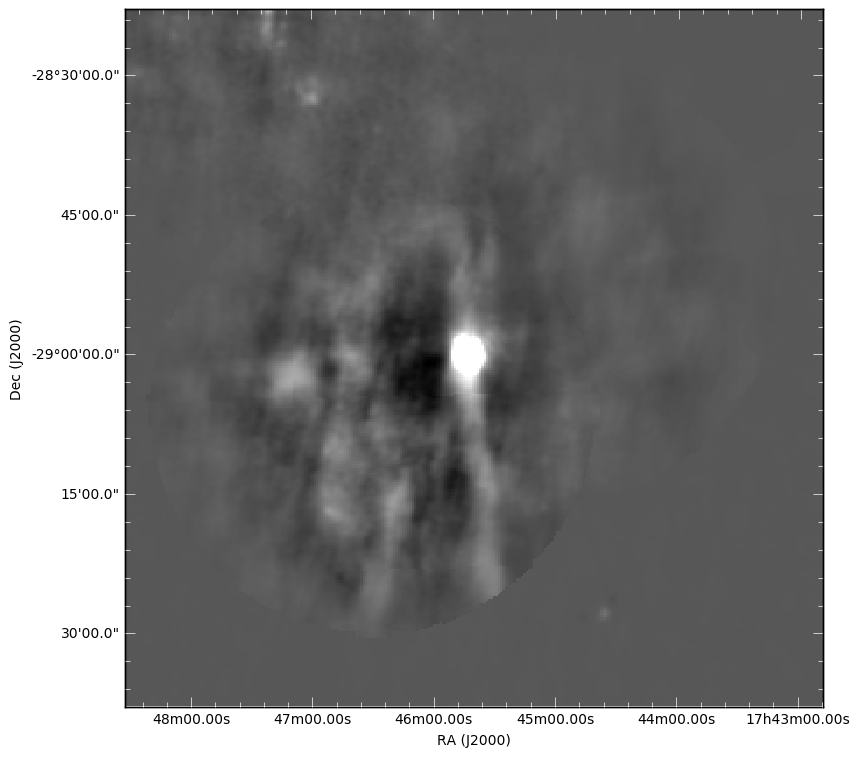

In [28]:
urllib.request.urlretrieve(res[0],'opt.fits')
hdulist = fits.open("opt.fits")
opt = hdulist[0] 
fig = aplpy.FITSFigure(opt)
fig.show_grayscale()

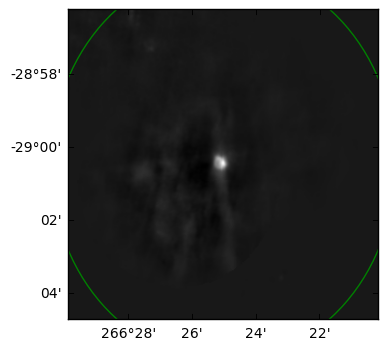

In [29]:
mycirc=interact(select_radius,radius=(0.0,max_radius,max_radius/1000))

In [48]:
limits = mycirc.widget.kwargs
rad    = limits['radius']
print(ra,dec)
rad

266.417 -29.0078


0.09

In [56]:
from astropy.vo.client import vos_catalog
catalog=vos_catalog.VOSCatalog.create("ChiVO ALMA",
                                      "http://10.6.91.206/archive_alma/q/scs-archive-alma/scs.xml?")
catalog.dumps()

'{\n    "title": "ChiVO ALMA",\n    "url": "http://10.6.91.206/archive_alma/q/scs-archive-alma/scs.xml?"\n}'

In [53]:
res=vos_catalog.call_vo_service('conesearch_good',
                            catalog_db=catalog,
                            kwargs={'RA': ra, 'DEC': dec,'SR': rad})

Trying http://10.6.91.206/archive_alma/q/scs-archive-alma/scs.xml?


VOSError: None of the available catalogs returned valid results.

In [39]:
almatab=res.to_table()
almatab.show_in_notebook()

AttributeError: 'list' object has no attribute 'to_table'

<IPython.core.display.Javascript object>


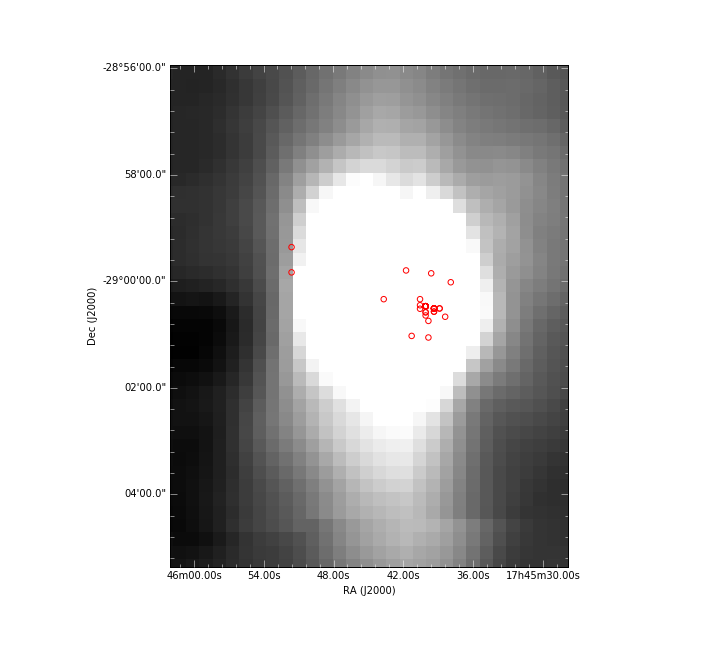

INFO: Auto-setting vmin to -1.796e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.434e+00 [aplpy.core]


In [338]:
%matplotlib notebook
fig = aplpy.FITSFigure(opt)
fig.show_grayscale()
fig.show_markers(almatab['s_ra'],almatab['s_dec'])

In [9]:
ra_max   = twhydra_cube.meta['NAXIS1']
dec_max  = twhydra_cube.meta['NAXIS2']
spec_max = twhydra_cube.meta['NAXIS3']

def cut_and_show(rlow=0,rhigh=ra_max,
                 dlow=0,dhigh=dec_max,
                 slow=0,shigh=spec_max,
                 threshold=0.0):
    # Cut the cube
    lower       = [slow,dlow,rlow]
    upper       = [shigh,dhigh,rhigh]
    tcube       = aca.cut(twhydra_cube,lower=lower,upper=upper)
    tcube       = aca.denoise(tcube,threshold=threshold)
    # Diplay
    plt.figure()
    plt.subplot(2,3,1)
    plt.imshow(tcube.data.sum(axis=(0)),origin='lower')
    plt.subplot(2,3,2)
    plt.imshow(tcube.data.sum(axis=(1)),origin='lower')
    plt.subplot(2,3,3)
    plt.imshow(tcube.data.sum(axis=(2)),origin='lower')
    plt.subplot(2,1,2)
    show_spectra(tcube)
    plt.show()

res=interact(cut_and_show,
             rlow=(0,ra_max), rhigh=(0,ra_max),
             dlow=(0,dec_max),dhigh=(0,dec_max),
             slow=(0,spec_max),shigh=(0,spec_max),
             threshold=(mmin,mmax))

AttributeError: 'PrimaryHDU' object has no attribute 'meta'

In [ ]:
lower        = [limits['slow'],limits['dlow'],limits['rlow']]
upper       = [limits['shigh'],limits['dhigh'],limits['rhigh']]
twhydra_crop = aca.cut(twhydra_cube,lower=lower,upper=upper)
print("MOMENT 0")
aca.visualize(aca.moment0(twhydra_crop),contour=True)
plt.show()
print("MOMENT 1")
(stcrop,a,b) = aca.standarize(twhydra_crop)
aca.visualize(aca.moment1(stcrop),contour=True)
plt.show()

## 3.- Analysis
First let us standarize the data

In [ ]:
(twhydra_cube,a,b) = aca.standarize(twhydra_cube)
lower        = [limits['slow'],limits['dlow'],limits['rlow']]
upper       = [limits['shigh'],limits['dhigh'],limits['rhigh']]
twhydra_crop = aca.cut(twhydra_cube,lower=lower,upper=upper)
mmax = twhydra_cube.data.max()
mmin = twhydra_cube.data.min()
(a,b)

In [ ]:
res_noise=interact(cut_and_show,
             rlow=(0,ra_max), rhigh=(0,ra_max),
             dlow=(0,dec_max),dhigh=(0,dec_max),
             slow=(0,spec_max),shigh=(0,spec_max), 
             threshold=(mmin,mmax))

In [ ]:
limits = res_noise.widget.kwargs
lower        = [limits['slow'],limits['dlow'],limits['rlow']]
upper       = [limits['shigh'],limits['dhigh'],limits['rhigh']]
noise_crop = aca.cut(twhydra_cube,lower=lower,upper=upper)
myrms=aca.rms(noise_crop.data)
myrms

## Obtain the PHR!

In [ ]:
(rep,syn,res)=aca.core.scatpix_detect(twhydra_crop.data,threshold=3.0*myrms,noise=myrms,full_output=True)
print(len(rep))
print(res.size)

In [ ]:
plt.figure()
syn2D=syn.sum(axis=(0))
vm=syn2D.max()
plt.subplot(121)
plt.imshow(syn2D,vmin=0,vmax=vm,origin='lower')
plt.subplot(122)
plt.imshow(res.sum(axis=(0)),vmin=0,vmax=vm,origin='lower')
plt.colorbar()
plt.show()

In [ ]:
from sompy.sompy import SOMFactory
newRep=rep['center'].data
sm = SOMFactory().build(newRep, normalization = 'var', initialization='pca')
sm.train(n_job=1, verbose=False, train_rough_len=30, train_finetune_len=30)

In [ ]:
sm.codebook.matrix

In [ ]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
def show_manifold(sm):
    cbook=sm.codebook.matrix
    fig=plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(cbook[:,0],cbook[:,1], cbook[:,2],c=cbook[:,0])#, c=c, marker=m)
    for cb,dm_elm in zip(cbook,sm._distance_matrix):
        conn=(dm_elm==1).nonzero()
        for idx in conn[0]:
            ot=cbook[idx]
            ax.plot([cb[0],ot[0]],[cb[1],ot[1]],[cb[2],ot[2]],color = 'Grey',alpha=0.5)
    plt.show()
show_manifold(sm)

## 4.- M100

In [ ]:
%matplotlib inline
# Extract File
download_extract_and_move(m100_url,m100_file)
# Load Fileinline
hdulist = fits.open(DOWNLOADS_DIR+'/'+m100_file)
m100_cube    = aca.HDU_to_NDData(hdulist[0])

In [ ]:
m100_cube.meta

In [ ]:
(ext1,ext2)=aca.extent(m100_cube)
ext1

In [ ]:
ext2

In [ ]:
cent=aca.center(m100_cube)
cent

In [ ]:
max_radius=(ext1[2]-cent[2])
max_radius.value

In [ ]:
%matplotlib inline
import aplpy
from astropy import units as u
from matplotlib.patches import Circle, Rectangle
(m100_cube,a,b) = aca.standarize(m100_cube)
m100_m0 = aca.moment0(m100_cube)


def select_radius(radius=max_radius.value):
    ax=plt.subplot(111,projection=m100_m0.wcs)
    ax.imshow(m100_m0.data,origin='lower',cmap='Greys')
    cc = Circle((cent[2].value,cent[1].value), radius=radius, edgecolor='green', facecolor='none',transform=ax.get_transform('fk5'))
    ax.add_patch(cc)

mycirc=interact(select_radius,radius=(0.0,max_radius.value,max_radius.value/1000))

In [ ]:
rad=mycirc.widget.kwargs['radius']
rad=(rad*u.deg).to('arcsec')
rad

In [ ]:
from astroquery import *
from astropy import coordinates
from astroquery.vizier import Vizier
catalog_list = Vizier.find_catalogs(keywords=['allWISE'])
for key,item in catalog_list.items():
    print(key+" : "+item.description)

In [ ]:
pos=coordinates.SkyCoord(cent[2],cent[1])
#print (fov*u.deg).to('arcsec')
#print cen*u.deg
tablist=Vizier.query_region(coordinates=pos,radius=rad)

In [ ]:
tablist

In [ ]:
atable=tablist['I/337/gaia']
atable

In [ ]:
fig = aplpy.FITSFigure(aca.NDData_to_HDU(m100_m0))
fig.show_grayscale()
fig.show_markers(atable['_RAJ2000'],atable['_DEJ2000'])

In [ ]:
%matplotlib inline
mside=(ext1[2] - ext2[2]).value
oside=(ext2[1] - ext1[1]).value



def select_noise(rside=mside/10.0,dside=oside/10.0,ra=cent[2].value,dec=cent[1].value,vini=ext1[0].value,vfin=ext2[0].value):
    ax=plt.subplot(121,projection=m100_m0.wcs)
    ax.imshow(m100_m0.data,origin='lower',cmap='Greys')
    cc = Rectangle((ra-rside,dec-dside),2*rside,2*dside,edgecolor='green', facecolor='none',transform=ax.get_transform('fk5'))
    ax.add_patch(cc)
    ax2=plt.subplot(122)
    ld=np.rint(m100_cube.wcs.wcs_world2pix([[ra-rside,dec-dside,vini]],0))
    lu=np.rint(m100_cube.wcs.wcs_world2pix([[ra+rside,dec+dside,vfin]],0))
    lower=np.array([ld,lu]).min(axis=0)[0]
    upper=np.array([ld,lu]).max(axis=0)[0]
    newcube=aca.cut(m100_cube,lower=lower[::-1],upper=upper[::-1])
    show_spectra(newcube)
    plt.show()


myrect=interact(select_noise,
                rside=(0.0,mside,mside/1000.0),
                dside=(0.0,oside,oside/1000.0),
                ra=(ext2[2].value,ext1[2].value,mside/1000.0),
                dec=(ext1[1].value,ext2[1].value,oside/1000.0),
                vini=(ext1[0].value,ext2[0].value),
                vfin=(ext1[0].value,ext2[0].value))

In [ ]:
print(oside)


In [ ]:
twhydra_cube    = aca.HDU_to_NDData(hdulist[0])